# SOL-PMT meta
Create meta for SOL-PMT from the original SOL-O.9HQ dataset. SOL-PMT: subset of SOL-O.9HQ, comprising 5 types of periodic modulation techniques.
1. Check meta information of the original SOL-O.9HQ dataset
2. Collect PMTs and generate meta, including label and data split
3. Content investigation of SOL-PMT: playing technique histograms, pitch range and number of mutes

In [1]:
import pandas as pd
import os
import glob
import collections as cl
import shutil
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
# follow paper class order
class_map = {'vibrato': 0,
             'trill': 1,
             'tremolo': 2,
             'bisbigliando': 3,
             'flatterzunge': 4
             }
             
# class abbrevation map
class_abbrv = {'vibrato': 'vib',
               'trill': 'trill',
               'tremolo': 'trem',
               'bisbigliando': 'bisb',
               'flatterzunge': 'flatt'
              }

## SOL-0.9HQ meta

In [3]:
# find all .wav files in subdirectories
data_dir = '/home/changhongw/datasets/SOL_0.9_HQ/'
wav_files = glob.glob(data_dir+ "**/**.wav", recursive = True)

for k in range(len(wav_files)):
    wav_files[k] = wav_files[k].replace(data_dir, '')

In [4]:
# find technique names with "non", e.g "nonvib" = non-vibrato
tech_with_non = []
for wav in wav_files:
    if 'non' in wav:
        tech_with_non.append(os.path.normpath(wav).split(os.sep)[-2])
len(tech_with_non)

1894

In [5]:
# create a DataFrame to save dataset meta information
meta = pd.DataFrame(columns=['instrument family', 'instrument', 
        'technique original', 'modulation technique', 'file_name'])

meta['instrument family'] = [os.path.normpath(wav).split(os.sep)[0] for wav in wav_files]
meta['instrument'] = [os.path.normpath(wav).split(os.sep)[1] for wav in wav_files]
meta['technique original'] = [os.path.normpath(wav).split(os.sep)[2] for wav in wav_files]
meta['modulation technique'] = ['other'] * len(meta)
meta['file_name'] = [os.path.normpath(wav).split(os.sep)[-1] for wav in wav_files]
len(meta['technique original'].unique())

143

In [6]:
# get modulation technique based on file name

for k in range(len(meta)):
    for class_name in class_abbrv:
        if class_abbrv[class_name] in meta['file_name'][k]:
            if 'nonvib' in meta['file_name'][k]:
                meta['modulation technique'][k] = 'other'
            else:
                meta['modulation technique'][k] = class_name

## SOL-PMT

In [7]:
meta_PMT = meta.loc[meta["modulation technique"] != 'other']
meta_PMT = meta_PMT.reset_index(drop=True)
meta_PMT

,instrument family,instrument,technique original,modulation technique,file_name
0,Clarinets,Clarinet-Bb,trill-minor-second-up,trill,BbCl-trill-min2-A4-mf.wav
1,Clarinets,Clarinet-Bb,trill-minor-second-up,trill,BbCl-trill-min2-D3-mf.wav
2,Clarinets,Clarinet-Bb,trill-minor-second-up,trill,BbCl-trill-min2-E3-mf.wav
3,Clarinets,Clarinet-Bb,trill-minor-second-up,trill,BbCl-trill-min2-E5-mf.wav
4,Clarinets,Clarinet-Bb,trill-minor-second-up,trill,BbCl-trill-min2-A#4-mf.wav
...,...,...,...,...,...
5559,Strings,Viola-sordina,tremolo,tremolo,Va+S-trem-A#4-mf-1c.wav
5560,Strings,Viola-sordina,tremolo,tremolo,Va+S-trem-E5-mf-1c.wav
5561,Strings,Viola-sordina,tremolo,tremolo,Va+S-trem-B5-mf-1c.wav
5562,Strings,Viola-sordina,tremolo,tremolo,Va+S-trem-F4-mf-2c.wav


In [8]:
cl.Counter(meta_PMT['modulation technique'])

Counter({'trill': 1035,
         'flatterzunge': 1523,
         'bisbigliando': 286,
         'tremolo': 2530,
         'vibrato': 190})

## create data split according to meta

In [9]:
df = meta_PMT
df_split = pd.DataFrame(columns=['instrument family', 'instrument', 
        'technique original', 'modulation technique', 'file_name', 'subset', 'label'])
df_shuffled = df.sample(frac=1, random_state=0)
df_shuffled

,instrument family,instrument,technique original,modulation technique,file_name
871,Tubas,Bass-Tuba,trill-major-second-up,trill,BBTb-trill-maj2-F#2-mf.wav
2200,Trombones,Tenor-Trombone,vibrato,vibrato,TTbn-vib-A2-f.wav
1427,Trumpets,Trumpet-C,flatterzunge-to-ordinario,flatterzunge,TpC-flatt_ord-F4-f.wav
5159,Strings,Violoncello,tremolo,tremolo,Vc-trem-D#2-ff-4c.wav
1185,Oboes,Oboe,vibrato,vibrato,Ob-vib-A#5-mf.wav
...,...,...,...,...,...
4931,Strings,Violoncello,sul-tasto-tremolo,tremolo,Vc-tasto-trem-D3-mf-3c.wav
3264,Strings,Viola,tremolo,tremolo,Va-trem-C#5-mf-1c.wav
1653,Trumpets,Trumpet-C-straight,flatterzunge,flatterzunge,TpC+S-flatt-F4-mf.wav
2607,Strings,Violin-sordina,tremolo,tremolo,Vn+S-trem-C6-ff-2c.wav


In [10]:
for tech in class_map:
    df_tech = df_shuffled[df_shuffled['modulation technique'] == tech] # shuffle dataset before spliting
    # split each class into training-validation-test by ratio 6:2:2
    for inst in df_tech['instrument'].unique():
        df_inst_class = df_tech[df_tech['instrument']==inst].reset_index(drop=True)
        df_inst_class['subset'] = ['training'] * int(len(df_inst_class) * 0.6) + \
                               ['validation'] * int(len(df_inst_class) * 0.2) + \
                               ['test'] * (len(df_inst_class) - int(len(df_inst_class) * 0.6) - int(len(df_inst_class) * 0.2))
        df_inst_class['label'] = [class_map[tech]] * len(df_inst_class)
        df_split = df_split.append(df_inst_class, ignore_index=True)

/tmp/ipykernel_66346/2212194546.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_split = df_split.append(df_inst_class, ignore_index=True)
/tmp/ipykernel_66346/2212194546.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_split = df_split.append(df_inst_class, ignore_index=True)
/tmp/ipykernel_66346/2212194546.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_split = df_split.append(df_inst_class, ignore_index=True)
/tmp/ipykernel_66346/2212194546.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_split = df_split.append(df_inst_class, ignore_index=True)
/tmp/ipykernel_66346/2212194546.py:10: FutureWarning: The fr

In [11]:
cl.Counter(df_split['modulation technique'])

Counter({'vibrato': 190,
         'trill': 1035,
         'tremolo': 2530,
         'bisbigliando': 286,
         'flatterzunge': 1523})

In [12]:
# these 5 samples with the same pitch (A4/A#4) are included in the test set for local-relevance map demonstration

df_split.loc[df_split['file_name'] == 'Bn-vib-A4-mf.wav', 'subset'] = 'test'
df_split.loc[df_split['file_name'] == 'Vn-trill-maj2-A#4-mf-2c.wav', 'subset'] = 'test'
df_split.loc[df_split['file_name'] == 'Vn+S-trem-A4-ff-4c.wav', 'subset'] = 'test'
df_split.loc[df_split['file_name'] == 'Hp-bisb-A4-mf.wav', 'subset'] = 'test'
df_split.loc[df_split['file_name'] == 'Bn-flatt-A4-mf.wav', 'subset'] = 'test'

In [13]:
meta_PMT = df_split
meta_PMT

,instrument family,instrument,technique original,modulation technique,file_name,subset,label
0,Trombones,Tenor-Trombone,vibrato,vibrato,TTbn-vib-A2-f.wav,training,0
1,Trombones,Tenor-Trombone,vibrato,vibrato,TTbn-vib-D3-p.wav,training,0
2,Trombones,Tenor-Trombone,vibrato,vibrato,TTbn-vib-E2-mf.wav,training,0
3,Trombones,Tenor-Trombone,vibrato,vibrato,TTbn-vib-B3-p.wav,training,0
4,Trombones,Tenor-Trombone,vibrato,vibrato,TTbn-vib-F#2-fff.wav,training,0
...,...,...,...,...,...,...,...
5559,Trumpets,Trumpet-C-cup,flatterzunge,flatterzunge,TpC+C-flatt-A5-mf.wav,test,4
5560,Trumpets,Trumpet-C-cup,flatterzunge,flatterzunge,TpC+C-flatt-G#4-mf.wav,test,4
5561,Trumpets,Trumpet-C-cup,flatterzunge,flatterzunge,TpC+C-flatt-D#4-mf.wav,test,4
5562,Trumpets,Trumpet-C-cup,flatterzunge,flatterzunge,TpC+C-flatt-G4-mf.wav,test,4


### pitch range of SOL-PMT

In [14]:
keys = ['C', 'D', 'E', 'F', 'G', 'A', 'B']
pitch = []

for wav in df['file_name']:
    if set(keys).intersection(wav.split('-')[-2]):
        pitch.append(wav.split('-')[-2])
    elif set(keys).intersection(wav.split('-')[-3]):
        pitch.append(wav.split('-')[-3])

len(set(pitch))

83

In [15]:
freq = [librosa.note_to_hz(item) for item in pitch]
print(librosa.hz_to_note(min(freq)), min(freq))
print(librosa.hz_to_note(max(freq)), max(freq))

C♯1 34.64782887210901
B7 3951.066410048992


### histogram over instruments

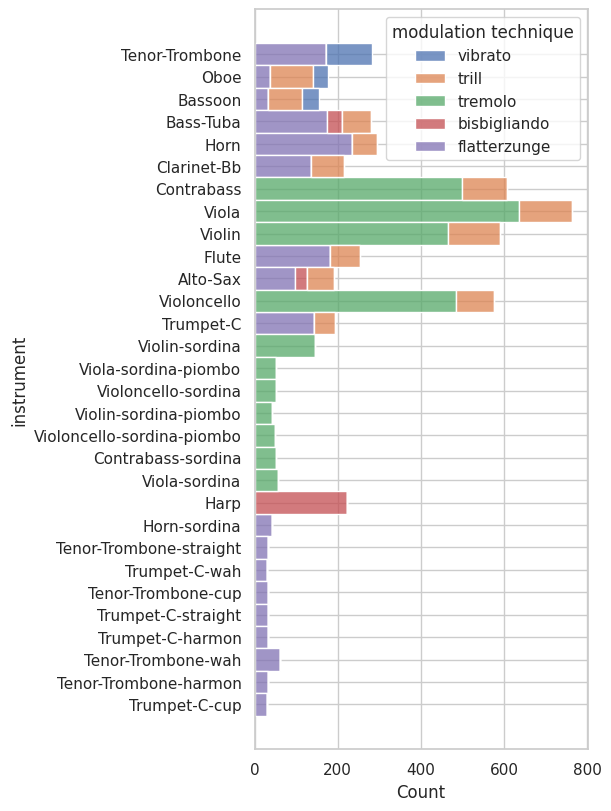

In [16]:
plt.rcParams['figure.constrained_layout.use'] = True
sns.set_theme(context='notebook', style='whitegrid')
plt.figure(figsize=(6,8))
ax = sns.histplot(data=meta_PMT, y="instrument", hue="modulation technique", multiple="stack")
# plt.ylim(-.5, 29.5)
# plt.savefig('results/playtech_histogram_instruments.pdf')
plt.savefig('results/playtech_histogram_instruments.png')

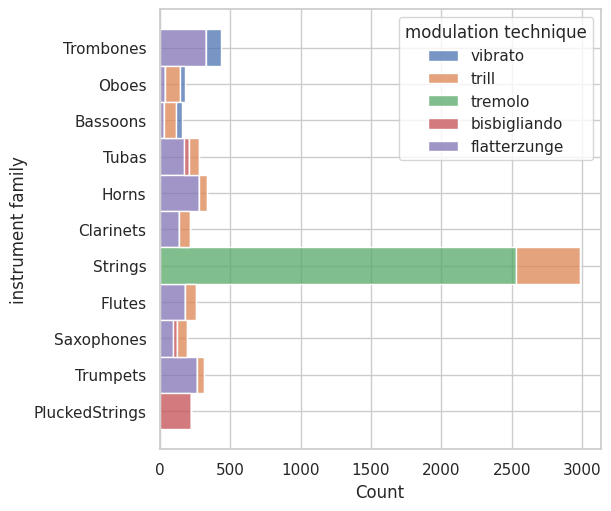

In [17]:
plt.rcParams['figure.constrained_layout.use'] = True
sns.set_theme(context='notebook', style='whitegrid')
plt.figure(figsize=(6,5))
ax = sns.histplot(data=meta_PMT, y="instrument family", hue="modulation technique", multiple="stack")
# plt.ylim(-.5, 11.5)
# plt.savefig('results/playtech_histogram_instrufamily.pdf')
plt.savefig('results/playtech_histogram_instrufamily.png')

## check mute 

In [18]:
# find all .wav files in subdirectories
data_dir = '/home/changhongw/datasets/SOL_0.9_HQ/'
wav_files = glob.glob(data_dir+ "**/**.wav", recursive = True)

for k in range(len(wav_files)):
    wav_files[k] = wav_files[k].replace(data_dir, '')

In [19]:
# "sordina" means "mute" in Italian
mute = [os.path.normpath(file).split(os.sep)[1] if 'sordina' in file else None for file in wav_files]
cl.Counter(mute)

Counter({None: 23296,
         'Horn-sordina': 87,
         'Oboe-sordina': 36,
         'Violin-sordina': 574,
         'Viola-sordina-piombo': 125,
         'Contrabass-sordina': 351,
         'Violoncello-sordina-piombo': 143,
         'Violoncello-sordina': 351,
         'Violin-sordina-piombo': 123,
         'Viola-sordina': 380})

## create a separate directory for SOL-PMT

In [20]:
modu_dir = '/home/changhongw/datasets/SOL-0.9HQ-PMT/'
modu_wav = [os.path.join(row['instrument family'], row['instrument'], row['technique original'],
            row['file_name']) for idx, row in meta_PMT.iterrows()]

In [21]:
wav_dir = set([os.path.split(wav)[0] for wav in modu_wav])
for wav in wav_dir:
    os.makedirs(modu_dir + wav) 

for wav in modu_wav:
    shutil.copy(data_dir + wav, modu_dir + wav)

In [22]:
# check number of modulation technique audio files
wav_files = glob.glob(modu_dir+ "**/**.wav", recursive = True)

for k in range(len(wav_files)):
    wav_files[k] = wav_files[k].replace(modu_dir, '')

In [23]:
# save meta_PMT
meta_PMT = meta_PMT.sample(frac=1, random_state=0)
meta_PMT.to_csv(modu_dir + 'SOL-0.9HQ-PMT_meta.csv', index=False)
meta_PMT

,instrument family,instrument,technique original,modulation technique,file_name,subset,label
871,Flutes,Flute,trill-major-second-up,trill,Fl-trill-maj2-G#6-mf.wav,training,1
2200,Strings,Contrabass,tremolo,tremolo,Cb-trem-F#2-mf-2c.wav,test,2
1427,Strings,Violoncello,tremolo,tremolo,Vc-trem-A4-pp-1c.wav,training,2
5159,Horns,Horn,ordinario-to-flatterzunge,flatterzunge,Hn-ord_flatt-E4-f.wav,training,4
1185,Trumpets,Trumpet-C,trill-major-second-up,trill,TpC-trill-maj2-A3-mf.wav,training,1
...,...,...,...,...,...,...,...
4931,Tubas,Bass-Tuba,flatterzunge-to-ordinario,flatterzunge,BBTb-flatt_ord-A3-mf.wav,training,4
3264,Strings,Viola,tremolo,tremolo,Va-trem-B6-mf-1c.wav,validation,2
1653,Strings,Violoncello,sul-ponticello-tremolo,tremolo,Vc-pont-trem-E4-mf-1c.wav,test,2
2607,Strings,Violin,artificial-harmonic-tremolo,tremolo,Vn-art-harm-trem-C7-mf-2c.wav,test,2


In [24]:
print(len(meta_PMT[meta_PMT['subset'] == 'training']), len(meta_PMT[meta_PMT['subset'] == 'validation']),
len(meta_PMT[meta_PMT['subset'] == 'test']))

3315 1098 1151


In [25]:
# save class_abbrevation
with open(modu_dir + 'class_abbrevation.json', 'w') as f:
    json.dump(class_abbrv, f)